In [1]:
import numpy as np
import matplotlib.pyplot as plt
import heat
%pylab inline
%load_ext autoreload  
%autoreload 2
from scipy import ndimage
#from scipy.interpolate import interpn
#from transformations import *  # handy set of rotation routines!!!!


Populating the interactive namespace from numpy and matplotlib


In [2]:
matplotlib.rcParams.update({'font.size': 20})

In [3]:
# make a file name for code outputs, can be used to make heat file names too
def nodefilename(froot,suffix,index):
    num1 = '{0:d}'.format(index)
    ff = froot + '_'
    if (index < 100000):
        ff = ff + '0'
    if (index < 10000):
        ff = ff + '0'
    if (index < 1000):
        ff = ff + '0'
    if (index < 100):
        ff = ff + '0'
    if (index < 10):
        ff = ff + '0'
    ff = ff + num1 + suffix
    print(ff)
    return ff

# for testing
#froot = '../heat_s18/a1'; suffix = '_node.txt'
#nfile = nodefilename(froot,suffix,6)
#print(nfile); #../heat_s18/a1_000006_node.txt



In [4]:
# return a meshgrid and linspaces and actual spacing dx_actual
def mkgrid(dx,xmax):
    #dy = dx
    xmin = -xmax;
    ymax = xmax; ymin = -ymax;
    nx = np.int((xmax-xmin)/dx) + 1;
    ny = nx
    xlinsp = np.linspace(xmin,xmax,nx)
    ylinsp = np.linspace(ymin,ymax,ny)
    yarrh,xarrh = np.meshgrid(ylinsp,xlinsp)  #nontrivial order here, is flipped
    #xarrh[i,*] gives x depending on i and is all the same for second index
    dx_actual = xlinsp[1]- xlinsp[0]  # dx is not exact
    return dx_actual,xlinsp,yarrh,xarrh
    

In [5]:
#   passing xarr,yarr,zarr coordinate arrays
#   temperature array is tarr
#   averaging those within a distance of midplane 
#   use Gaussian weighting as a function of distance from plane
#   binning uses dx and xmax to make grid
def tempxysig(xarr,yarr,zarr,tarr,dx,xmax,sigz,nrand):
    dx_actual,xlinsp,yarrh,xarrh = mkgrid(dx,xmax)  # grid
    mhist = xarrh*0.0;
    mrhist = xarrh*0.0;
    whist = xarrh*0.0;
    poff = 0.0;  # pixel offset
    rarr = np.sqrt(xarr**2 + yarr**2 + zarr**2)
    n = np.size(xarr);
    for i in range (0,n):  # loop over particles
        if (np.abs(zarr[i]) < 3*sigz):
            for k in range(nrand):
                xg = xarr[i] 
                yg = yarr[i] 
                zg = zarr[i] 
                if (nrand >1):
                    xg += np.random.normal(0.0,dx_actual/2)
                    yg += np.random.normal(0.0,dx_actual/2)
                    zg += np.random.normal(0.0,dx_actual/2) 
                weight = np.exp(-0.5*(zg/sigz)**2) # gaussian weight
                xi = np.int((xg - np.min(xlinsp))/dx_actual + poff);
                yi = np.int((yg - np.min(xlinsp))/dx_actual + poff);
                if ((xi >=0) and (xi<np.size(xlinsp))):
                    if ((yi >=0) and (yi<np.size(xlinsp))):
                        mhist[xi,yi]+= weight*tarr[i]  # averaging with weights via z
                        mrhist[xi,yi]+= weight*tarr[i]*rarr[i]  # T*r
                        #checked order!
                        whist[xi,yi]+= weight; 
                        
    jj = np.where(whist >0.0)
    mhist[jj] = mhist[jj]/whist[jj]
    #mhist = mhist/whist
    mrhist = mrhist/whist
    return xarrh,yarrh,mhist,mrhist   # note order



In [6]:
#   passing xarr,yarr,zarr coordinate arrays
#   heat array is harr
#   summing those within a distance of midplane 
#   use Gaussian weighting as a function of distance from plane
#   binning uses dx and xmax to make grid
# integral of  e^-x^2 is sqrt pi
def heatxysig(xarr,yarr,zarr,harr,dx,xmax,sigz,nrand):
    dx_actual,xlinsp,yarrh,xarrh = mkgrid(dx,xmax)    # grid
    pixarea =  dx_actual**2; 
    mhist = xarrh*0.0;
    mrhist = xarrh*0.0;
    whist = xarrh*0.0;
    poff = 0.0;  # pixel offset
    rarr = np.sqrt(xarr**2 + yarr**2 + zarr**2)
    fac = 1.0/np.sqrt(2.0*np.pi) * (1.0/sigz) # for normalization of z part
    fac = fac/nrand/pixarea
    n = np.size(xarr);
    for i in range (0,n):  # loop over particles
        if (np.abs(zarr[i]) < 3*sigz):
            for k in range(nrand):
                xg = xarr[i] 
                yg = yarr[i] 
                zg = zarr[i] 
                if (nrand >1):
                    xg += np.random.normal(0.0,dx_actual/2)
                    yg += np.random.normal(0.0,dx_actual/2)
                    zg += np.random.normal(0.0,dx_actual/2) 
                zg2 = 0.5*(zg/sigz)**2  # is positive
                weight = np.exp(-zg2) # gaussian weight
                xi = np.int((xg - np.min(xlinsp))/dx_actual + poff);
                yi = np.int((yg - np.min(xlinsp))/dx_actual + poff);
                if ((xi >=0) and (xi<np.size(xlinsp))):
                    if ((yi >=0) and (yi<np.size(xlinsp))):
                        mhist[xi,yi]+= weight*harr[i]  # sumk with weights via z
                        mrhist[xi,yi]+= weight*harr[i]*rarr[i]  # T*r
                        #checked order!
                        whist[xi,yi]+= weight; 
    mhist = mhist*fac  # normalize heat/volume                    
    #jj = np.where(whist >0.0)
    #mhist[jj] = mhist[jj]/whist[jj]
    #mhist = mhist/whist
    #mrhist = mrhist/whist
    return xarrh,yarrh,mhist,mrhist   # note order



In [7]:
def plt_temp(froot,index,dx,sigz,xmax,vmax):
    suffix = '_node.txt'
    nfile0 = nodefilename(froot,suffix,0)
    iarr,xarr0,yarr0,zarr0,vxarr,vyarr,vzarr,tarr,cv,surf = np.loadtxt(nfile0, skiprows=2, unpack=True)
    nfile = nodefilename(froot,suffix,index)
    iarr,xarr,yarr,zarr,vxarr,vyarr,vzarr,tarr,cv,surf = np.loadtxt(nfile, skiprows=2, unpack=True)
    #xmax = 1.1
    #dx = 0.10
    #sigz = 0.15
    xarrh,yarrh,mhist,mrhist  = tempxysig(xarr0,yarr0,zarr0,tarr,dx,xmax,sigz)
    f, axarr = plt.subplots(1,1,sharex=True,sharey=True,figsize=(8.5,6));
    img=axarr.pcolormesh(xarrh,yarrh,mhist,vmin=0,vmax=vmax,cmap='inferno')
    axarr.set_aspect(1.0);
    cbar_ax = f.add_axes([0.830, 0.17, 0.03, 0.68])
    f.colorbar(img, cax=cbar_ax,format='%.1e')
    
def plt3_temp(froot,index,dx,sigz,multr,xmax,nsmo):
    nrand=3
    #nsmo =0.5
    suffix = '_node.txt'
    nfile0 = nodefilename(froot,suffix,0)
    iarr,xarr0,yarr0,zarr0,vxarr,vyarr,vzarr,tarr,cv,surf,marr,xrotarr,yrotarr = \
        np.loadtxt(nfile0, skiprows=2, unpack=True)
    nfile = nodefilename(froot,suffix,index)
    iarr,xarr,yarr,zarr,vxarr,vyarr,vzarr,tarr,cv,surf,marr,xrotarr,yrotarr = \
        np.loadtxt(nfile, skiprows=2, unpack=True)
    xarrh_a,yarrh_a,mhist_a,mrhist_a  = tempxysig(xarr0,yarr0,zarr0,tarr,dx,xmax,sigz,nrand)
    xarrh_b,zarrh_b,mhist_b,mrhist_b  = tempxysig(xarr0,zarr0,yarr0,tarr,dx,xmax,sigz,nrand)
    yarrh_c,zarrh_c,mhist_c,mrhist_c  = tempxysig(yarr0,zarr0,xarr0,tarr,dx,xmax,sigz,nrand)
    rarr0=np.sqrt(xarr0**2 + yarr0**2 + zarr0**2)
    
    f, axarr = plt.subplots(1,3,sharex=True,sharey=True,figsize=(8.5,3));
    f.subplots_adjust(hspace=0);
    f.subplots_adjust(wspace=0.05);
    f.subplots_adjust(left=0.07)
    f.subplots_adjust(right=0.80)
    #plt.axis('tight');
    x1 = xarrh_a
    #plt.axis([x1.min(), x1.max(), x1.min(), x1.max()]);
    plt.setp([a.get_xticklabels() for a in f.axes], visible=False) ;
    plt.setp([a.get_yticklabels() for a in f.axes], visible=False) ;
    plt.setp(axarr[0].get_xticklabels(), visible=True) ;
    plt.setp(axarr[0].get_yticklabels(), visible=True) ;
    axarr[0].set_xlim([-xmax,xmax])
    axarr[0].set_ylim([-xmax,xmax])
    for i in range(0,3):
        axarr[i].set_aspect(1.0);
        axarr[i].set_adjustable('box-forced')
    
    lmin=-5
    lmax=0
    llev = np.linspace(lmin,lmax,(lmax-lmin)*3+1)
    levels = 10.0**llev
    if (multr==1):
        rarrh = np.sqrt(xarrh_a**2 + yarrh_a**2)
        max_all = np.max(tarr*rarr0)
        #img=axarr[0].pcolormesh(xarrh_a,yarrh_a,mhist_a*rarrh,vmin=0,vmax=max_all,cmap='inferno')
        #img=axarr[1].pcolormesh(xarrh_b,zarrh_b,mhist_b*rarrh,vmin=0,vmax=max_all,cmap='inferno')
        #img=axarr[2].pcolormesh(yarrh_c,zarrh_c,mhist_c*rarrh,vmin=0,vmax=max_all,cmap='inferno')
        img=axarr[0].pcolormesh(xarrh_a,yarrh_a,mrhist_a,vmin=0,vmax=max_all,cmap='inferno')
        img=axarr[1].pcolormesh(xarrh_b,zarrh_b,mrhist_b,vmin=0,vmax=max_all,cmap='inferno')
        img=axarr[2].pcolormesh(yarrh_c,zarrh_c,mrhist_c,vmin=0,vmax=max_all,cmap='inferno')
    else:
        img_a = ndimage.gaussian_filter(mhist_a,nsmo)
        img_b = ndimage.gaussian_filter(mhist_b,nsmo)
        img_c = ndimage.gaussian_filter(mhist_c,nsmo)
        max_all = np.max(img_a)
        img=axarr[0].pcolormesh(xarrh_a,yarrh_a,img_a,vmin=0,vmax=max_all,cmap='inferno')
        img=axarr[1].pcolormesh(xarrh_b,zarrh_b,img_b,vmin=0,vmax=max_all,cmap='inferno')
        img=axarr[2].pcolormesh(yarrh_c,zarrh_c,img_c,vmin=0,vmax=max_all,cmap='inferno')
        #levels = (1e-3,1e-2,1e-1)
        col= 'cyan'
        dx_actual = xarrh_a[1][1] - xarrh_a[0][0]
        print(dx_actual)
        xc_a = xarrh_a[:-1, :-1] + dx_actual/2.
        yc_a = yarrh_a[:-1, :-1] + dx_actual/2.
        xc_b = xarrh_b[:-1, :-1] + dx_actual/2.
        zc_b = zarrh_b[:-1, :-1] + dx_actual/2.
        yc_c = yarrh_c[:-1, :-1] + dx_actual/2.
        zc_c = zarrh_c[:-1, :-1] + dx_actual/2.
        cs = axarr[0].contour(xc_a,yc_a,mhist_a[:-1, :-1],levels,colors=col)
        cs = axarr[1].contour(xc_b,zc_b,mhist_b[:-1, :-1],levels,colors=col)
        cs = axarr[2].contour(yc_c,zc_c,mhist_c[:-1, :-1],levels,colors=col)
        axarr[0].plot((0),(0),'k+')
        axarr[1].plot((0),(0),'k+')
        axarr[2].plot((0),(0),'k+')

    cbar_ax = f.add_axes([0.830, 0.17, 0.03, 0.68])
    f.colorbar(img, cax=cbar_ax,format='%.1e')
    d1=0.07; v1=0.05;
    d2=0.07; v2=0.09;
    pm = x1.max();
    xyzcolor='lightgreen'
    axarr[0].text( pm-d1,-pm+v1,'x',ha='center',va='bottom',fontsize=16,color=xyzcolor);
    axarr[0].text(-pm+d2, pm-v2,'y',ha='left',va='center',fontsize=16,color=xyzcolor);
    axarr[1].text( pm-d1,-pm+v1,'x',ha='center',va='bottom',fontsize=16,color=xyzcolor);
    axarr[1].text(-pm+d2, pm-v2,'z',ha='left',va='center',fontsize=16,color=xyzcolor);
    axarr[2].text( pm-d1,-pm+v1,'y',ha='center',va='bottom',fontsize=16,color=xyzcolor);
    axarr[2].text(-pm+d2, pm-v2,'z',ha='left',va='center',fontsize=16,color=xyzcolor);
    #    plt.savefig(fname);




In [14]:
def plt3_heat(froot,index,di,dx,sigz,multr,xmax,nsmo,ofile):
    nrand=1
    #nsmo =0.5
    suffix = '_heat.txt'
    dx_actual,xlinsp,yarrh,xarrh = mkgrid(dx,xmax)   
    mhist_a = 0*xarrh
    mhist_b = 0*xarrh
    mhist_c = 0*xarrh
    if (di==0):
        print("plt3_heat: di==0!!! no data")
    for i in range(0,di):
        nfile = nodefilename(froot,suffix,index+i)
        iarr,xarr,yarr,zarr,dedt,xrot,yrot = \
            np.loadtxt(nfile, skiprows=2, unpack=True)
        xarrh_a,yarrh_a,mhist_ai,mrhist_a  = heatxysig(xrot,yrot,zarr,dedt,dx,xmax,sigz,nrand)
        xarrh_b,zarrh_b,mhist_bi,mrhist_b  = heatxysig(xrot,zarr,yrot,dedt,dx,xmax,sigz,nrand)
        yarrh_c,zarrh_c,mhist_ci,mrhist_c  = heatxysig(yrot,zarr,xrot,dedt,dx,xmax,sigz,nrand)
        mhist_a += mhist_ai
        mhist_b += mhist_bi
        mhist_c += mhist_ci
    if (di >0):
        mhist_a /= di
        mhist_b /= di
        mhist_c /= di
        
    #rarr0=np.sqrt(xarr0**2 + yarr0**2 + zarr0**2)
    
    f, axarr = plt.subplots(1,3,sharex=True,sharey=True,figsize=(8.5,3));
    f.subplots_adjust(hspace=0);
    f.subplots_adjust(wspace=0.05);
    f.subplots_adjust(left=0.07)
    f.subplots_adjust(right=0.80)

    plt.setp([a.get_xticklabels() for a in f.axes], visible=False) ;
    plt.setp([a.get_yticklabels() for a in f.axes], visible=False) ;
    plt.setp(axarr[0].get_xticklabels(), visible=True) ;
    plt.setp(axarr[0].get_yticklabels(), visible=True) ;
    axarr[0].set_xlim([-xmax,xmax])
    axarr[0].set_ylim([-xmax,xmax])
    for i in range(0,3):
        axarr[i].set_aspect(1.0);
        axarr[i].set_adjustable('box-forced')

    img_a = ndimage.gaussian_filter(mhist_a,nsmo)
    img_b = ndimage.gaussian_filter(mhist_b,nsmo)
    img_c = ndimage.gaussian_filter(mhist_c,nsmo)
    max_all = np.max([np.max(img_a),np.max(img_b), np.max(img_c)])
    img=axarr[0].pcolormesh(xarrh_a,yarrh_a,img_a,vmin=0,vmax=max_all,cmap='inferno')
    img=axarr[1].pcolormesh(xarrh_a,yarrh_a,img_b,vmin=0,vmax=max_all,cmap='inferno')
    img=axarr[2].pcolormesh(xarrh_a,yarrh_a,img_c,vmin=0,vmax=max_all,cmap='inferno')
    
    for i in range(0,3):
        axarr[i].plot((0),(0),'r+')

    cbar_ax = f.add_axes([0.81, 0.17, 0.03, 0.68])
    f.colorbar(img, cax=cbar_ax,format='%.1e')
    d1=0.07; v1=0.05;
    d2=0.07; v2=0.09;
    pm = xmax;
    xyzcolor='lightgreen'
    axarr[0].text( pm-d1,-pm+v1,'x',ha='center',va='bottom',fontsize=16,color=xyzcolor);
    axarr[0].text(-pm+d2, pm-v2,'y',ha='left',va='center',fontsize=16,color=xyzcolor);
    axarr[1].text( pm-d1,-pm+v1,'x',ha='center',va='bottom',fontsize=16,color=xyzcolor);
    axarr[1].text(-pm+d2, pm-v2,'z',ha='left',va='center',fontsize=16,color=xyzcolor);
    axarr[2].text( pm-d1,-pm+v1,'y',ha='center',va='bottom',fontsize=16,color=xyzcolor);
    axarr[2].text(-pm+d2, pm-v2,'z',ha='left',va='center',fontsize=16,color=xyzcolor);
    
    if (len(ofile) > 2):
        plt.savefig(ofile)




In [9]:
def plt_tarr(froot,index):
    f, axarr = plt.subplots(1,3,sharex=True,sharey=True,figsize=(8.5,3));
    f.subplots_adjust(hspace=0);
    f.subplots_adjust(wspace=0.05);
    f.subplots_adjust(left=0.07)
    f.subplots_adjust(right=0.82)
    suffix = '_node.txt'
    nfile = nodefilename(froot,suffix,index)
    iarr,xarr,yarr,zarr,vxarr,vyarr,vzarr,tarr,cv,surf,marr,xrotarr,yrotarr = np.loadtxt(nfile, skiprows=2, unpack=True)
    rarr = np.sqrt(xarr**2 + yarr**2 + zarr**2); 
    jj1 = np.where((np.fabs(zarr)<0.2) & (xarr>0) & (np.fabs(yarr)<0.2))
    jj2 = np.where((np.fabs(zarr)<0.2) & (xarr<0) & (np.fabs(yarr)<0.2))
    jj3 = np.where((np.fabs(yarr)<0.2) & (np.fabs(xarr)<0.2))
    jj4 = np.where((np.fabs(yarr)<0.2) & (np.fabs(zarr)<0.2))
    axarr[0].plot(rarr[jj1],tarr[jj1],'r.',ms=1)
    axarr[0].plot(rarr[jj2],tarr[jj2],'b.',ms=1)
    axarr[1].plot(rarr[jj3],tarr[jj3],'g.',ms=1)
    axarr[1].plot(rarr[jj4],tarr[jj4],'m.',ms=1)
    
    
def plt_dedt(froot,index):
    f, axarr = plt.subplots(1,3,sharex=True,sharey=True,figsize=(8.5,3));
    f.subplots_adjust(hspace=0);
    f.subplots_adjust(wspace=0.05);
    f.subplots_adjust(left=0.07)
    f.subplots_adjust(right=0.82)
    suffix = '_heat.txt'
    nfile = nodefilename(froot,suffix,index)
    iarr,xarr,yarr,zarr,dedt,ang1,ang2 = np.loadtxt(nfile, skiprows=2, unpack=True)
    rarr = np.sqrt(xarr**2 + yarr**2 + zarr**2); 
    jj1 = np.where((np.fabs(zarr)<0.2) & (xarr>0) & (np.fabs(yarr)<0.2))
    jj2 = np.where((np.fabs(zarr)<0.2) & (xarr<0) & (np.fabs(yarr)<0.2))
    jj3 = np.where((np.fabs(yarr)<0.2) & (np.fabs(xarr)<0.2))
    jj4 = np.where((np.fabs(yarr)<0.2) & (np.fabs(zarr)<0.2))
    axarr[0].plot(rarr[jj1],dedt[jj1],'r.',ms=1)
    axarr[0].plot(rarr[jj2],dedt[jj2],'b.',ms=1)
    axarr[1].plot(rarr[jj3],dedt[jj3],'g.',ms=1)
    axarr[1].plot(rarr[jj4],dedt[jj4],'m.',ms=1)

In [10]:
# extract the time from the top of the _node file or _heat file dependent on suffix
def extract_time(froot,index,suffix):
    #froot = '../moon_heat/n1_out/n1'; 
    #index = 5
    #suffix = '_heat.txt'
    nfile = nodefilename(froot,suffix,index)
    infile = open(nfile, 'r')
    firstLine = infile.readline()
    #print(firstLine)
    time_a = np.fromstring(firstLine[1:], dtype=double, sep=' ')
    time = time_a[0]
    #print(time)
    infile.close()
    return time

    
# tests
#froot = '../moon_heat/n1_out/n1'
#index=5
#suffix = '_heat.txt'
#time = extract_time(froot,index,suffix)
#print(time)

In [11]:
# for all simulations
xmax = 1.1
sigz = 0.20
dx = 0.08
nsmo=1

../moon_heat/m2_out/m2_000045_heat.txt
../moon_heat/m2_out/m2_000046_heat.txt
../moon_heat/m2_out/m2_000047_heat.txt
../moon_heat/m2_out/m2_000048_heat.txt
../moon_heat/m2_out/m2_000049_heat.txt
../moon_heat/m2_out/m2_000050_heat.txt
../moon_heat/m2_out/m2_000051_heat.txt
../moon_heat/m2_out/m2_000052_heat.txt
../moon_heat/m2_out/m2_000053_heat.txt
../moon_heat/m2_out/m2_000054_heat.txt


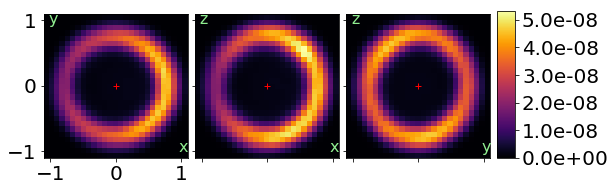

In [15]:
froot = '../moon_heat/m2_out/m2'; 
index=45
#plt3_temp(froot,index,dx,sigz,1,xmax)
#plt3_temp(froot,index,dx,sigz,0,xmax,nsmo)
plt3_heat(froot,index,10,dx,sigz,0,xmax,1,'m2heat.png')
#plt_tarr(froot,index)
#plt_tarr(froot,index+10)

../moon_heat/m1_out/m1_000000_node.txt
../moon_heat/m1_out/m1_000008_node.txt


//anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


0.0814814814815
../moon_heat/m1_out/m1_000008_heat.txt
../moon_heat/m1_out/m1_000008_heat.txt
../moon_heat/m1_out/m1_000009_heat.txt
../moon_heat/m1_out/m1_000010_heat.txt
../moon_heat/m1_out/m1_000011_heat.txt
../moon_heat/m1_out/m1_000012_heat.txt
../moon_heat/m1_out/m1_000013_heat.txt
../moon_heat/m1_out/m1_000008_node.txt


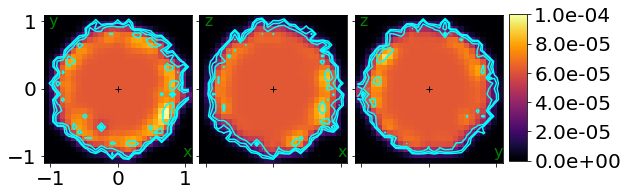

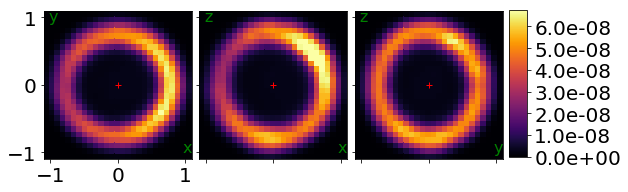

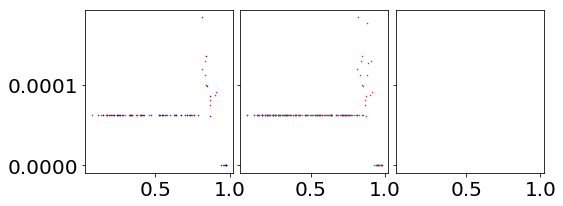

In [23]:
froot = '../moon_heat/m1_out/m1'; 
index=8
#plt3_temp(froot,index,dx,sigz,1,xmax)
plt3_temp(froot,index,dx,sigz,0,xmax,nsmo)
plt3_heat(froot,index,6,dx,sigz,0,xmax,1,'')
plt_tarr(froot,index)
#plt_tarr(froot,index+10)